## Imports & Path

In [36]:
import os, sys
sys.path.append(os.path.abspath(".."))

import pandas as pd

from src.data_loader import MarketDataConfig, fetch_prices, compute_returns
from src.portfolio import Portfolio, portfolio_returns
from src.var_models import historical_var, parametric_var_normal
from src.backtest import var_exceptions, exception_summary, exception_table
from src.plots import plot_var_overlay
from src.scaling import scale_to_dollars


## Config & Data

In [37]:
cfg = MarketDataConfig(
    tickers=["SPY", "TLT", "GLD", "UUP"],
    start="2015-01-01",
    use_log_returns=True
)

prices = fetch_prices(cfg)
rets = compute_returns(prices, use_log=cfg.use_log_returns)

prices.tail(), rets.tail()


(Ticker             GLD         SPY        TLT    UUP
 Date                                                
 2026-02-11  467.630005  691.960022  88.059998  26.83
 2026-02-12  451.390015  681.270020  89.230003  26.82
 2026-02-13  462.619995  681.750000  89.720001  26.82
 2026-02-17  448.200012  682.849976  89.870003  26.91
 2026-02-18  458.279999  686.289978  89.529999  27.08,
 Ticker           GLD       SPY       TLT       UUP
 Date                                              
 2026-02-11  0.011247 -0.000231 -0.005323  0.001119
 2026-02-12 -0.035346 -0.015569  0.013199 -0.000373
 2026-02-13  0.024574  0.000704  0.005476  0.000000
 2026-02-17 -0.031666  0.001612  0.001670  0.003350
 2026-02-18  0.022241  0.005025 -0.003790  0.006297)

## Portfolio

In [38]:
port = Portfolio(weights={"SPY": 0.4, "TLT": 0.3, "GLD": 0.2, "UUP": 0.1})
pret = portfolio_returns(rets, port)
NOTIONAL = 10_000_000  # $10mm demo notional 
pnl = scale_to_dollars(pret, NOTIONAL) # use helper to scale pre-trade into dollars  

pret.describe()


count    2797.000000
mean        0.000303
std         0.005438
min        -0.045450
25%        -0.002396
50%         0.000622
75%         0.003174
max         0.049112
Name: portfolio_return, dtype: float64

## VaR Models

In [45]:
WINDOW = 252

# Historical VaR
var95_hist = historical_var(pret, window=WINDOW, alpha=0.05)
var95_hist_dollars = scale_to_dollars(var95_hist, NOTIONAL)
var99_hist = historical_var(pret, window=WINDOW, alpha=0.01)
var99_hist_dollars = scale_to_dollars(var99_hist, NOTIONAL)

# Parametric VaR
var95_param = parametric_var_normal(pret, window=WINDOW, alpha=0.05, use_mean=True)
var95_param_dollars = scale_to_dollars(var95_param, NOTIONAL)
var99_param = parametric_var_normal(pret, window=WINDOW, alpha=0.01, use_mean=True)
var99_param_dollars = scale_to_dollars(var99_param, NOTIONAL)

pd.concat([pret*100, var95_hist_dollars, var95_param_dollars, var99_hist_dollars, var99_param_dollars], axis=1).dropna().head()


,portfolio_return,portfolio_return_dollars,portfolio_return_dollars,portfolio_return_dollars,portfolio_return_dollars
Date,,,,,
2016-01-04,-0.051974,-75126.77452,-75472.070641,-127716.602477,-106383.814718
2016-01-05,0.060825,-75126.77452,-75471.393166,-127716.602477,-106383.230177
2016-01-06,0.153428,-75126.77452,-75466.462324,-127716.602477,-106334.985542
2016-01-07,-0.738171,-75126.77452,-76184.096318,-127716.602477,-107170.243167
2016-01-08,-0.376598,-75126.77452,-76476.226427,-127716.602477,-107478.711205


## Backtest Summaries

In [40]:
b95 = var_exceptions(pnl, var95_hist_dollars)
b99 = var_exceptions(pnl, var99_hist_dollars)

sum95 = exception_summary(b95, alpha=0.05)
sum99 = exception_summary(b99, alpha=0.01)

pd.DataFrame([sum95, sum99], index=["VaR95", "VaR99"])


,n_obs,alpha,breaches,expected_breaches,breach_rate
VaR95,2546,0.05,128,127.30,0.050275
VaR99,2546,0.01,33,25.46,0.012962


## Exception Table

In [ ]:
# Use helper to get exceptions. Print top 5 of 95% & 99%
exc95 = exception_table(pnl, var95_hist_dollars, top_n=1000)
exc99 = exception_table(pnl, var99_hist_dollars, top_n=1000)

## Save all exceptions to csv files
os.makedirs("../outputs", exist_ok=True)
exc95.to_csv("../outputs/var95_exceptions.csv")
exc99.to_csv("../outputs/var99_exceptions.csv")
print("Saved:", "../outputs/var95_exceptions.csv", "../outputs/var99_exceptions.csv\n")

## Print worst day data
worst_day_95 = exc95.index[0] if len(exc95) else None
if worst_day_95:
    row = exc95.loc[worst_day_95]
    print(f"Worst 95% VaR breach day: {worst_day_95.date()}")
    print(f"Realized P&L: ${row['realized']:,.0f}")
    print(f"VaR threshold: ${row['var']:,.0f}")
    print(f"Exceedance (Realized - VaR): ${row['exceedance']:,.0f}\n")
else:
    print("No breaches found in sample (unexpected for long history).")
print("95% Top 5 worst days\n", exc95.head(), "\n")

worst_day_99 = exc99.index[0] if len(exc99) else None
if worst_day_99:
    row = exc99.loc[worst_day_99]
    print(f"Worst 99% VaR breach day: {worst_day_99.date()}")
    print(f"Realized P&L: ${row['realized']:,.0f}")
    print(f"VaR threshold: ${row['var']:,.0f}")
    print(f"Exceedance (Realized - VaR): ${row['exceedance']:,.0f}\n")
else:
    print("No breaches found in sample (unexpected for long history).")
print("99% Top 5 worst days", exc99.head())


Saved: ../outputs/var95_exceptions.csv ../outputs/var99_exceptions.csv

Worst 95% VaR breach day: 2020-03-12
Realized P&L: $-454,504
VaR threshold: $-59,407
Exceedance (Realized - VaR): $-395,097

95% Top 5 worst days
                  realized            var  breach     exceedance
Date                                                           
2020-03-12 -454504.403005  -59407.016923    True -395097.386082
2020-03-18 -407228.823969  -64189.315169    True -343039.508800
2020-03-16 -330904.525390  -61374.013140    True -269530.512251
2020-03-11 -317988.027400  -57751.155383    True -260236.872016
2022-06-13 -294355.645687 -105287.595338    True -189068.050350
Worst 99% VaR breach day: 2020-03-12
Realized P&L: $-454,504
VaR threshold: $-203,838
Exceedance (Realized - VaR): $-250,667
99% Top 5 worst days                  realized            var  breach     exceedance
Date                                                           
2020-03-12 -454504.403005 -203837.637026    True -250666.76

## Plots (in $)

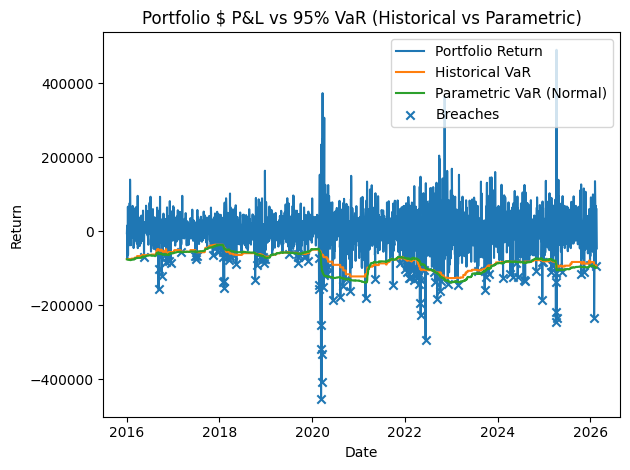

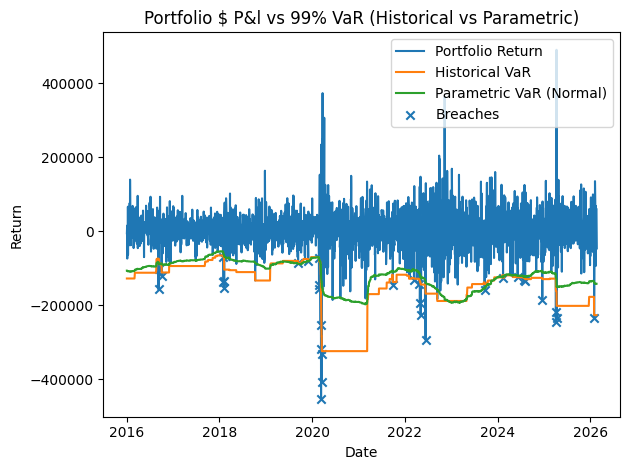

In [42]:
plot_var_overlay(
    returns=pnl,
    var_hist=var95_hist_dollars,
    var_param=var95_param_dollars,
    title="Portfolio $ P&L vs 95% VaR (Historical vs Parametric)",
    outpath="../outputs/figures/var_95_overlay_dollars.png",
)
plot_var_overlay(
    returns=pnl,
    var_hist=var99_hist_dollars,
    var_param=var99_param_dollars,
    title="Portfolio $ P&l vs 99% VaR (Historical vs Parametric)",
    outpath="../outputs/figures/var_99_overlay_dollars.png",
)


## Pre-Trade Impact (Simple)

In [43]:
port_new = Portfolio(weights={"SPY": 0.6, "TLT": 0.2, "GLD": 0.1, "UUP": 0.1})

pret_new = portfolio_returns(rets, port_new)
pnl_new = scale_to_dollars(pret_new, NOTIONAL)

var95_hist_new = historical_var(pret_new, window=WINDOW, alpha=0.05)
var95_param_new = parametric_var_normal(pret_new, window=WINDOW, alpha=0.05, use_mean=True)
var99_hist_new = historical_var(pret_new, window=WINDOW, alpha=0.01)
var99_param_new = parametric_var_normal(pret_new, window=WINDOW, alpha=0.01, use_mean=True)

var95_hist_new_dollars = scale_to_dollars(var95_hist_new, NOTIONAL)
var95_param_new_dollars = scale_to_dollars(var95_param_new, NOTIONAL)
var99_hist_new_dollars = scale_to_dollars(var99_hist_new, NOTIONAL)
var99_param_new_dollars = scale_to_dollars(var99_param_new, NOTIONAL)

comparison = pd.DataFrame({
    "VaR95_hist_old_$": var95_hist_dollars.dropna().round(2),
    "VaR95_hist_new_$": var95_hist_new_dollars.dropna().round(2),
    "VaR95_param_old_$": var95_param_dollars.dropna().round(2),
    "VaR95_param_new_$": var95_param_new_dollars.dropna().round(2),
    "VaR99_hist_old_$": var99_hist_dollars.dropna().round(2),
    "VaR99_hist_new_$": var99_hist_new_dollars.dropna().round(2),
    "VaR99_param_old_$": var99_param_dollars.dropna().round(2),
    "VaR99_param_new_$": var99_param_new_dollars.dropna().round(2),
}).dropna()

comparison.tail().round(2)


,VaR95_hist_old_$,VaR95_hist_new_$,VaR95_param_old_$,VaR95_param_new_$,VaR99_hist_old_$,VaR99_hist_new_$,VaR99_param_old_$,VaR99_param_new_$
Date,,,,,,,,
2026-02-11,-92022.69,-108563.14,-98037.38,-122096.86,-226877.24,-236788.2,-141505.55,-175046.60
2026-02-12,-93042.17,-110004.06,-98761.90,-122918.74,-226877.24,-236788.2,-142420.42,-176065.31
2026-02-13,-93042.17,-110004.06,-98309.46,-122524.71,-226877.24,-236788.2,-141977.04,-175647.30
2026-02-17,-93042.17,-110004.06,-98593.85,-122633.56,-226877.24,-236788.2,-142130.27,-175615.60
2026-02-18,-93042.17,-110004.06,-98404.58,-122482.45,-226877.24,-236788.2,-141988.46,-175498.16


## Summary of Pre-Trade Change

In [44]:
latest = comparison.iloc[-1]
delta_hist_95 = latest["VaR95_hist_new_$"] - latest["VaR95_hist_old_$"]
delta_param_95 = latest["VaR95_param_new_$"] - latest["VaR95_param_old_$"]
delta_hist_99 = latest["VaR99_hist_new_$"] - latest["VaR99_hist_old_$"]
delta_param_99 = latest["VaR99_param_new_$"] - latest["VaR99_param_old_$"]

print("95% VaR Pre-Trade Change")
print(f"VaR95_hist_old_$: {latest['VaR95_hist_old_$']:.2f}")
print(f"VaR95_hist_new_$: {latest['VaR95_hist_new_$']:.2f}")
print(f"VaR95_param_old_$: {latest['VaR95_param_old_$']:.2f}")
print(f"VaR95_param_new_$: {latest['VaR95_param_new_$']:.2f}")
print(f"delta_hist_$: {delta_hist_95:.2f}")
print(f"delta_param_$: {delta_param_95:.2f}\n")
print("99% VaR Pre-Trade Change")
print(f"VaR99_hist_old_$: {latest['VaR99_hist_old_$']:.2f}")
print(f"VaR99_hist_new_$: {latest['VaR99_hist_new_$']:.2f}")
print(f"VaR99_param_old_$: {latest['VaR99_param_old_$']:.2f}")
print(f"VaR99_param_new_$: {latest['VaR99_param_new_$']:.2f}")
print(f"delta_hist_$: {delta_hist_99:.2f}")
print(f"delta_param_$: {delta_param_99:.2f}")


95% VaR Pre-Trade Change
VaR95_hist_old_$: -93042.17
VaR95_hist_new_$: -110004.06
VaR95_param_old_$: -98404.58
VaR95_param_new_$: -122482.45
delta_hist_$: -16961.89
delta_param_$: -24077.87

99% VaR Pre-Trade Change
VaR99_hist_old_$: -226877.24
VaR99_hist_new_$: -236788.20
VaR99_param_old_$: -141988.46
VaR99_param_new_$: -175498.16
delta_hist_$: -9910.96
delta_param_$: -33509.70
